In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os

## 1.CNN

In [32]:
# 定義是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設置
EPOCH = 100  
BATCH_SIZE = 50      
LR = 0.001        

#prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #padding=4，則上下左右均填充4個pixel，若為32 32，則會變成40 40
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                #將圖片轉換為Tensor，歸一化製[0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #把0-1變換到(-1,1)
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #CIFAR-10數據分布
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.ImageFolder(root='./CIFAR-10/train/', transform=transform_train) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成一個個batch進行批訓練，組成batch的時候順序打亂取

testset = torchvision.datasets.ImageFolder(root='./CIFAR-10/test/', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# Cifar-10的標籤
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [33]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #128x16x16
        )      
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #32x8x8
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*8*8, 128), #128
            nn.ReLU()
        )
        self.out = nn.Linear(128, self.num_classes) #10

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        output = self.out(x)
        return output

In [34]:
# 模型定義-CNN
cnn = CNN().to(device)
# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #損失函數為交叉熵，多用於多分類問題
optimizer = optim.SGD(cnn.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，並採用L2正則化（權重衰減）

In [35]:
from tqdm import tqdm
import matplotlib.pyplot as plt

if not os.path.exists('./model/CNN/'):
    os.makedirs('./model/CNN/')

# 初始化 best test accuracy
best_acc = 0

# 初始化 loss 和 accuracy 列表
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Start Training, CNN!")
for epoch in range(EPOCH):
    cnn.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    train_iter = tqdm(trainloader, total=len(trainloader))
    for i, data in enumerate(train_iter, 0):
        # 準備數據
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每訓練1個batch打印一次loss和準確率
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels.data).cpu().sum()
        train_iter.set_description('[epoch:%d/%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                % (epoch + 1, EPOCH, (i + 1 + epoch * length), train_loss / (i + 1), 100. * train_correct / train_total))

    # 計算訓練集 loss 和 accuracy
    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #每訓練完一個epoch測試一下準確率
    # print("Waiting Test!")
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_iter = tqdm(testloader, total=len(testloader), desc='Testing')
        for data in test_iter:
            cnn.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            # 取得分最高的那個類 (outputs.data的索引號)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum()
            test_loss += criterion(outputs, labels).item()
            test_iter.set_postfix({'epoch': f'{epoch+1}/{EPOCH}','loss': test_loss / (test_iter.n + 1), 'acc': '{:.4%}'.format(test_correct / test_total)})
        test_loss /= len(testloader)
        test_acc = 100. * test_correct.cpu() / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f"finish {epoch+1} epochs")

        # 保存模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(cnn.state_dict(), '%s/net_best.pth' % ('./model/CNN'))
            
print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training, CNN!


[epoch:1/100, iter:40] Loss: 2.261 | Acc: 15.700% : 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s, epoch=1/100, loss=2.49, acc=26.5000%]
[epoch:2/100, iter:80] Loss: 2.075 | Acc: 26.600% : 100%|██████████| 40/40 [00:06<00:00,  6.48it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, epoch=2/100, loss=2.23, acc=32.7500%]
[epoch:3/100, iter:120] Loss: 1.885 | Acc: 32.050% : 100%|██████████| 40/40 [00:05<00:00,  6.85it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, epoch=3/100, loss=1.8, acc=38.0000%] 
[epoch:4/100, iter:160] Loss: 1.757 | Acc: 37.350% : 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s, epoch=4/100, loss=2.74, acc=38.0000%]
[epoch:5/100, iter:200] Loss: 1.703 | Acc: 37.250% : 100%|██████████| 40/40 [00:06<00:00,  6.26it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s, epoch=5/100, loss=1.87, acc=38.0000%]
[epoch:6/100, iter:240] Loss: 1.

finish 10 epochs


[epoch:11/100, iter:440] Loss: 1.414 | Acc: 48.800% : 100%|██████████| 40/40 [00:04<00:00,  8.37it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s, epoch=11/100, loss=2.35, acc=43.0000%]
[epoch:12/100, iter:480] Loss: 1.388 | Acc: 50.800% : 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.50it/s, epoch=12/100, loss=2.26, acc=48.5000%]
[epoch:13/100, iter:520] Loss: 1.354 | Acc: 50.600% : 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s, epoch=13/100, loss=1.63, acc=46.2500%]
[epoch:14/100, iter:560] Loss: 1.335 | Acc: 51.050% : 100%|██████████| 40/40 [00:06<00:00,  6.49it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s, epoch=14/100, loss=1.6, acc=45.7500%] 
[epoch:15/100, iter:600] Loss: 1.297 | Acc: 54.200% : 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.45it/s, epoch=15/100, loss=1.9, acc=46.5000%] 
[epoch:16/100, iter:

finish 20 epochs


[epoch:21/100, iter:840] Loss: 1.157 | Acc: 59.450% : 100%|██████████| 40/40 [00:06<00:00,  6.45it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s, epoch=21/100, loss=1.47, acc=52.2500%]
[epoch:22/100, iter:880] Loss: 1.132 | Acc: 60.250% : 100%|██████████| 40/40 [00:06<00:00,  6.32it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s, epoch=22/100, loss=1.45, acc=50.7500%]
[epoch:23/100, iter:920] Loss: 1.125 | Acc: 58.650% : 100%|██████████| 40/40 [00:06<00:00,  5.89it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s, epoch=23/100, loss=1.36, acc=49.7500%]
[epoch:24/100, iter:960] Loss: 1.113 | Acc: 60.250% : 100%|██████████| 40/40 [00:05<00:00,  7.27it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s, epoch=24/100, loss=1.3, acc=48.2500%] 
[epoch:25/100, iter:1000] Loss: 1.074 | Acc: 61.650% : 100%|██████████| 40/40 [00:06<00:00,  6.45it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s, epoch=25/100, loss=3.5, acc=53.2500%] 
[epoch:26/100, iter

finish 30 epochs


[epoch:31/100, iter:1240] Loss: 0.981 | Acc: 64.900% : 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s, epoch=31/100, loss=1.41, acc=53.7500%]
[epoch:32/100, iter:1280] Loss: 0.966 | Acc: 64.500% : 100%|██████████| 40/40 [00:06<00:00,  5.99it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s, epoch=32/100, loss=1.45, acc=54.5000%]
[epoch:33/100, iter:1320] Loss: 0.977 | Acc: 65.150% : 100%|██████████| 40/40 [00:06<00:00,  5.97it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s, epoch=33/100, loss=1.48, acc=52.2500%]
[epoch:34/100, iter:1360] Loss: 0.966 | Acc: 64.700% : 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s, epoch=34/100, loss=1.42, acc=53.7500%]
[epoch:35/100, iter:1400] Loss: 0.917 | Acc: 67.450% : 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, epoch=35/100, loss=1.44, acc=54.5000%]
[epoch:36/100, 

finish 40 epochs


[epoch:41/100, iter:1640] Loss: 0.834 | Acc: 71.050% : 100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s, epoch=41/100, loss=1.46, acc=54.5000%]
[epoch:42/100, iter:1680] Loss: 0.863 | Acc: 69.700% : 100%|██████████| 40/40 [00:05<00:00,  6.88it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, epoch=42/100, loss=1.36, acc=58.7500%]
[epoch:43/100, iter:1720] Loss: 0.828 | Acc: 70.900% : 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.00it/s, epoch=43/100, loss=1.42, acc=55.2500%]
[epoch:44/100, iter:1760] Loss: 0.830 | Acc: 70.650% : 100%|██████████| 40/40 [00:06<00:00,  6.48it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s, epoch=44/100, loss=1.52, acc=53.0000%]
[epoch:45/100, iter:1800] Loss: 0.798 | Acc: 71.150% : 100%|██████████| 40/40 [00:05<00:00,  7.00it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, epoch=45/100, loss=1.38, acc=55.0000%]
[epoch:46/100, 

finish 50 epochs


[epoch:51/100, iter:2040] Loss: 0.758 | Acc: 73.050% : 100%|██████████| 40/40 [00:06<00:00,  6.25it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s, epoch=51/100, loss=1.38, acc=56.7500%]
[epoch:52/100, iter:2080] Loss: 0.769 | Acc: 73.300% : 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, epoch=52/100, loss=1.44, acc=55.0000%]
[epoch:53/100, iter:2120] Loss: 0.729 | Acc: 73.600% : 100%|██████████| 40/40 [00:06<00:00,  6.63it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, epoch=53/100, loss=1.44, acc=57.2500%]
[epoch:54/100, iter:2160] Loss: 0.694 | Acc: 74.950% : 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, epoch=54/100, loss=1.38, acc=56.2500%]
[epoch:55/100, iter:2200] Loss: 0.717 | Acc: 74.800% : 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s, epoch=55/100, loss=1.59, acc=53.2500%]
[epoch:56/100, 

finish 60 epochs


[epoch:61/100, iter:2440] Loss: 0.652 | Acc: 76.000% : 100%|██████████| 40/40 [00:05<00:00,  7.57it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.53it/s, epoch=61/100, loss=2.09, acc=57.2500%]
[epoch:62/100, iter:2480] Loss: 0.645 | Acc: 77.700% : 100%|██████████| 40/40 [00:04<00:00,  8.05it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s, epoch=62/100, loss=3.61, acc=53.5000%]
[epoch:63/100, iter:2520] Loss: 0.620 | Acc: 78.200% : 100%|██████████| 40/40 [00:05<00:00,  6.74it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s, epoch=63/100, loss=1.54, acc=53.7500%]
[epoch:64/100, iter:2560] Loss: 0.654 | Acc: 77.350% : 100%|██████████| 40/40 [00:06<00:00,  6.49it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.49it/s, epoch=64/100, loss=1.47, acc=58.0000%]
[epoch:65/100, iter:2600] Loss: 0.641 | Acc: 77.000% : 100%|██████████| 40/40 [00:06<00:00,  6.54it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s, epoch=65/100, loss=1.22, acc=58.7500%]
[epoch:66/100, 

finish 70 epochs


[epoch:71/100, iter:2840] Loss: 0.543 | Acc: 81.150% : 100%|██████████| 40/40 [00:04<00:00,  8.29it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s, epoch=71/100, loss=1.26, acc=56.7500%]
[epoch:72/100, iter:2880] Loss: 0.545 | Acc: 80.250% : 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s, epoch=72/100, loss=2.13, acc=57.5000%] 
[epoch:73/100, iter:2920] Loss: 0.554 | Acc: 81.600% : 100%|██████████| 40/40 [00:05<00:00,  7.35it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.33it/s, epoch=73/100, loss=3.56, acc=60.0000%]
[epoch:74/100, iter:2960] Loss: 0.539 | Acc: 81.550% : 100%|██████████| 40/40 [00:04<00:00,  8.02it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s, epoch=74/100, loss=2.02, acc=58.5000%]
[epoch:75/100, iter:3000] Loss: 0.569 | Acc: 79.850% : 100%|██████████| 40/40 [00:06<00:00,  6.28it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s, epoch=75/100, loss=1.58, acc=54.7500%]
[epoch:76/100,

finish 80 epochs


[epoch:81/100, iter:3240] Loss: 0.492 | Acc: 83.950% : 100%|██████████| 40/40 [00:06<00:00,  6.57it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s, epoch=81/100, loss=1.45, acc=58.7500%]
[epoch:82/100, iter:3280] Loss: 0.529 | Acc: 81.650% : 100%|██████████| 40/40 [00:05<00:00,  6.69it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s, epoch=82/100, loss=1.31, acc=59.7500%]
[epoch:83/100, iter:3320] Loss: 0.501 | Acc: 81.500% : 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s, epoch=83/100, loss=1.69, acc=56.0000%]
[epoch:84/100, iter:3360] Loss: 0.515 | Acc: 81.300% : 100%|██████████| 40/40 [00:05<00:00,  6.94it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s, epoch=84/100, loss=1.34, acc=58.5000%]
[epoch:85/100, iter:3400] Loss: 0.498 | Acc: 82.050% : 100%|██████████| 40/40 [00:05<00:00,  7.67it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.49it/s, epoch=85/100, loss=2.84, acc=57.0000%]
[epoch:86/100, 

finish 90 epochs


[epoch:91/100, iter:3640] Loss: 0.435 | Acc: 84.550% : 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s, epoch=91/100, loss=3.65, acc=60.0000%]
[epoch:92/100, iter:3680] Loss: 0.447 | Acc: 84.350% : 100%|██████████| 40/40 [00:04<00:00,  8.49it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.49it/s, epoch=92/100, loss=2.19, acc=61.0000%]
[epoch:93/100, iter:3720] Loss: 0.399 | Acc: 86.550% : 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.54it/s, epoch=93/100, loss=2.7, acc=60.5000%] 
[epoch:94/100, iter:3760] Loss: 0.463 | Acc: 84.650% : 100%|██████████| 40/40 [00:04<00:00,  8.59it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.43it/s, epoch=94/100, loss=3.38, acc=62.0000%]
[epoch:95/100, iter:3800] Loss: 0.447 | Acc: 84.250% : 100%|██████████| 40/40 [00:04<00:00,  8.55it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s, epoch=95/100, loss=2.84, acc=59.5000%]
[epoch:96/100, 

finish 100 epochs
Training Finished, TotalEPOCH=100


### CNN Result

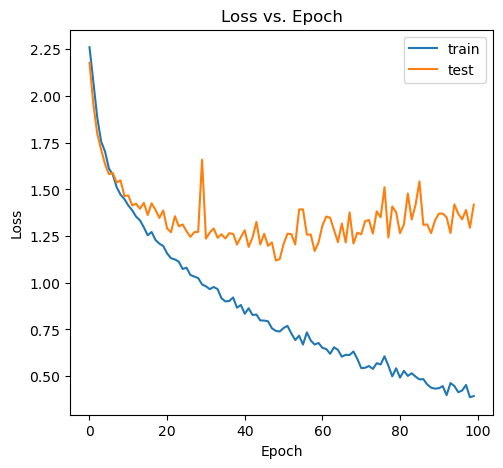

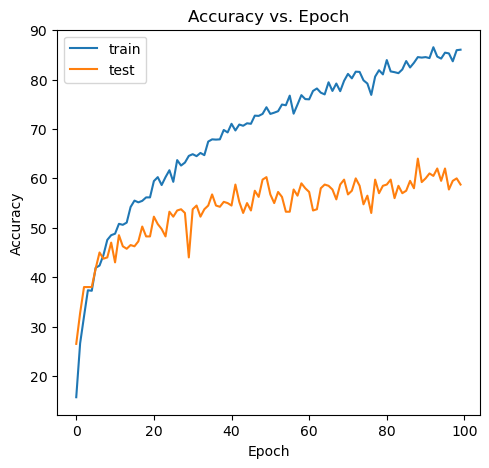

In [36]:
# 畫出 loss 和 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2(a).ResNet with residual blocks(ResNet18)

In [37]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

In [38]:
# 模型定義-ResNet
net = ResNet18().to(device)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，並採用L2正則化（權重衰減）

In [39]:
if not os.path.exists('./model/resnet18/'):
    os.makedirs('./model/resnet18/')

# 初始化 best test accuracy
best_acc = 0

# 初始化 loss 和 accuracy 列表
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Start Training, Resnet-18!")
for epoch in range(EPOCH):
    net.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    train_iter = tqdm(trainloader, total=len(trainloader))
    for i, data in enumerate(train_iter, 0):
        # 準備數據
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每訓練1個batch打印一次loss和準確率
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels.data).cpu().sum()
        train_iter.set_description('[epoch:%d/%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                % (epoch + 1, EPOCH, (i + 1 + epoch * length), train_loss / (i + 1), 100. * train_correct / train_total))

    # 計算訓練集 loss 和 accuracy
    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #每訓練完一個epoch測試一下準確率
    # print("Waiting Test!")
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_iter = tqdm(testloader, total=len(testloader), desc='Testing')
        for data in test_iter:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            # 取得分最高的那個類 (outputs.data的索引號)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum()
            test_loss += criterion(outputs, labels).item()
            test_iter.set_postfix({'epoch': f'{epoch+1}/{EPOCH}','loss': test_loss / (test_iter.n + 1), 'acc': '{:.4%}'.format(test_correct / test_total)})
        test_loss /= len(testloader)
        test_acc = 100. * test_correct.cpu() / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f"finish {epoch+1} epochs")

        # 保存模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(net.state_dict(), '%s/net_best.pth' % ('./model/resnet18/'))
            
print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training, Resnet-18!


[epoch:1/100, iter:40] Loss: 2.227 | Acc: 18.600% : 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s, epoch=1/100, loss=4.17, acc=20.0000%]
[epoch:2/100, iter:80] Loss: 1.923 | Acc: 26.850% : 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, epoch=2/100, loss=2.44, acc=33.5000%]
[epoch:3/100, iter:120] Loss: 1.762 | Acc: 33.450% : 100%|██████████| 40/40 [00:07<00:00,  5.33it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s, epoch=3/100, loss=2.52, acc=32.2500%]
[epoch:4/100, iter:160] Loss: 1.667 | Acc: 37.200% : 100%|██████████| 40/40 [00:07<00:00,  5.59it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s, epoch=4/100, loss=2.24, acc=35.5000%]
[epoch:5/100, iter:200] Loss: 1.615 | Acc: 39.750% : 100%|██████████| 40/40 [00:07<00:00,  5.23it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, epoch=5/100, loss=1.6, acc=38.5000%] 
[epoch:6/100, iter:240] Loss: 1.

finish 10 epochs


[epoch:11/100, iter:440] Loss: 1.300 | Acc: 51.700% : 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, epoch=11/100, loss=2.16, acc=42.2500%]
[epoch:12/100, iter:480] Loss: 1.224 | Acc: 56.200% : 100%|██████████| 40/40 [00:07<00:00,  5.21it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s, epoch=12/100, loss=2.05, acc=43.7500%]
[epoch:13/100, iter:520] Loss: 1.216 | Acc: 56.450% : 100%|██████████| 40/40 [00:06<00:00,  5.75it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s, epoch=13/100, loss=2.78, acc=42.7500%]
[epoch:14/100, iter:560] Loss: 1.180 | Acc: 56.600% : 100%|██████████| 40/40 [00:07<00:00,  5.67it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s, epoch=14/100, loss=1.59, acc=41.7500%]
[epoch:15/100, iter:600] Loss: 1.117 | Acc: 59.600% : 100%|██████████| 40/40 [00:06<00:00,  5.79it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.16it/s, epoch=15/100, loss=1.82, acc=44.0000%]
[epoch:16/100, iter:

finish 20 epochs


[epoch:21/100, iter:840] Loss: 0.839 | Acc: 69.100% : 100%|██████████| 40/40 [00:07<00:00,  5.68it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s, epoch=21/100, loss=1.59, acc=46.7500%]
[epoch:22/100, iter:880] Loss: 0.877 | Acc: 69.300% : 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s, epoch=22/100, loss=2.24, acc=48.7500%]
[epoch:23/100, iter:920] Loss: 0.827 | Acc: 70.450% : 100%|██████████| 40/40 [00:07<00:00,  5.67it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=23/100, loss=1.71, acc=49.5000%]
[epoch:24/100, iter:960] Loss: 0.804 | Acc: 71.800% : 100%|██████████| 40/40 [00:06<00:00,  5.75it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=24/100, loss=2.03, acc=46.2500%]
[epoch:25/100, iter:1000] Loss: 0.793 | Acc: 71.150% : 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=25/100, loss=2.96, acc=41.2500%]
[epoch:26/100, iter

finish 30 epochs


[epoch:31/100, iter:1240] Loss: 0.567 | Acc: 80.650% : 100%|██████████| 40/40 [00:06<00:00,  5.74it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s, epoch=31/100, loss=1.9, acc=46.5000%] 
[epoch:32/100, iter:1280] Loss: 0.558 | Acc: 81.350% : 100%|██████████| 40/40 [00:06<00:00,  5.73it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=32/100, loss=2.03, acc=50.5000%]
[epoch:33/100, iter:1320] Loss: 0.521 | Acc: 81.450% : 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s, epoch=33/100, loss=2.54, acc=50.7500%]
[epoch:34/100, iter:1360] Loss: 0.468 | Acc: 84.650% : 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s, epoch=34/100, loss=2.82, acc=51.0000%]
[epoch:35/100, iter:1400] Loss: 0.483 | Acc: 82.950% : 100%|██████████| 40/40 [00:06<00:00,  5.73it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s, epoch=35/100, loss=2.12, acc=48.7500%]
[epoch:36/100, 

finish 40 epochs


[epoch:41/100, iter:1640] Loss: 0.306 | Acc: 89.700% : 100%|██████████| 40/40 [00:07<00:00,  5.35it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s, epoch=41/100, loss=2.36, acc=53.0000%]
[epoch:42/100, iter:1680] Loss: 0.303 | Acc: 90.100% : 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, epoch=42/100, loss=2.45, acc=55.0000%]
[epoch:43/100, iter:1720] Loss: 0.252 | Acc: 92.200% : 100%|██████████| 40/40 [00:08<00:00,  4.94it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s, epoch=43/100, loss=2.98, acc=56.7500%]
[epoch:44/100, iter:1760] Loss: 0.300 | Acc: 90.100% : 100%|██████████| 40/40 [00:07<00:00,  5.31it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, epoch=44/100, loss=2.74, acc=50.0000%]
[epoch:45/100, iter:1800] Loss: 0.252 | Acc: 91.450% : 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, epoch=45/100, loss=2.28, acc=47.7500%]
[epoch:46/100, 

finish 50 epochs


[epoch:51/100, iter:2040] Loss: 0.211 | Acc: 92.750% : 100%|██████████| 40/40 [00:07<00:00,  5.43it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s, epoch=51/100, loss=3.3, acc=50.5000%] 
[epoch:52/100, iter:2080] Loss: 0.178 | Acc: 94.100% : 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s, epoch=52/100, loss=3.77, acc=52.5000%]
[epoch:53/100, iter:2120] Loss: 0.212 | Acc: 92.850% : 100%|██████████| 40/40 [00:06<00:00,  5.82it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.30it/s, epoch=53/100, loss=2.82, acc=53.2500%]
[epoch:54/100, iter:2160] Loss: 0.181 | Acc: 93.500% : 100%|██████████| 40/40 [00:06<00:00,  5.79it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.32it/s, epoch=54/100, loss=1.92, acc=55.7500%]
[epoch:55/100, iter:2200] Loss: 0.145 | Acc: 95.450% : 100%|██████████| 40/40 [00:07<00:00,  5.68it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s, epoch=55/100, loss=3.15, acc=53.5000%]
[epoch:56/100, 

finish 60 epochs


[epoch:61/100, iter:2440] Loss: 0.138 | Acc: 95.500% : 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.33it/s, epoch=61/100, loss=1.89, acc=56.5000%]
[epoch:62/100, iter:2480] Loss: 0.108 | Acc: 96.550% : 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s, epoch=62/100, loss=2.41, acc=55.7500%]
[epoch:63/100, iter:2520] Loss: 0.105 | Acc: 96.750% : 100%|██████████| 40/40 [00:06<00:00,  5.80it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s, epoch=63/100, loss=3.47, acc=54.2500%]
[epoch:64/100, iter:2560] Loss: 0.092 | Acc: 97.150% : 100%|██████████| 40/40 [00:06<00:00,  5.74it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=64/100, loss=1.89, acc=56.7500%]
[epoch:65/100, iter:2600] Loss: 0.089 | Acc: 97.000% : 100%|██████████| 40/40 [00:06<00:00,  5.76it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.29it/s, epoch=65/100, loss=3.56, acc=52.7500%]
[epoch:66/100, 

finish 70 epochs


[epoch:71/100, iter:2840] Loss: 0.087 | Acc: 97.150% : 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s, epoch=71/100, loss=2.42, acc=53.0000%]
[epoch:72/100, iter:2880] Loss: 0.070 | Acc: 98.050% : 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s, epoch=72/100, loss=2.45, acc=55.5000%]
[epoch:73/100, iter:2920] Loss: 0.070 | Acc: 98.100% : 100%|██████████| 40/40 [00:06<00:00,  5.79it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.29it/s, epoch=73/100, loss=2.36, acc=54.5000%]
[epoch:74/100, iter:2960] Loss: 0.086 | Acc: 97.300% : 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.26it/s, epoch=74/100, loss=2.64, acc=53.2500%]
[epoch:75/100, iter:3000] Loss: 0.067 | Acc: 97.650% : 100%|██████████| 40/40 [00:06<00:00,  5.78it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.27it/s, epoch=75/100, loss=2.91, acc=54.7500%]
[epoch:76/100, 

finish 80 epochs


[epoch:81/100, iter:3240] Loss: 0.058 | Acc: 98.550% : 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, epoch=81/100, loss=2.08, acc=56.7500%]
[epoch:82/100, iter:3280] Loss: 0.042 | Acc: 98.900% : 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, epoch=82/100, loss=2.69, acc=57.7500%]
[epoch:83/100, iter:3320] Loss: 0.046 | Acc: 99.000% : 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, epoch=83/100, loss=2.47, acc=59.5000%]
[epoch:84/100, iter:3360] Loss: 0.031 | Acc: 99.150% : 100%|██████████| 40/40 [00:07<00:00,  5.01it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.49it/s, epoch=84/100, loss=2.36, acc=57.7500%]
[epoch:85/100, iter:3400] Loss: 0.033 | Acc: 99.100% : 100%|██████████| 40/40 [00:07<00:00,  5.07it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.54it/s, epoch=85/100, loss=2.34, acc=59.0000%]
[epoch:86/100, 

finish 90 epochs


[epoch:91/100, iter:3640] Loss: 0.035 | Acc: 98.950% : 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s, epoch=91/100, loss=3.08, acc=55.7500%]
[epoch:92/100, iter:3680] Loss: 0.036 | Acc: 99.150% : 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.35it/s, epoch=92/100, loss=2.59, acc=55.2500%]
[epoch:93/100, iter:3720] Loss: 0.036 | Acc: 99.100% : 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s, epoch=93/100, loss=2.88, acc=57.5000%]
[epoch:94/100, iter:3760] Loss: 0.038 | Acc: 99.150% : 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s, epoch=94/100, loss=2.49, acc=53.7500%]
[epoch:95/100, iter:3800] Loss: 0.028 | Acc: 99.200% : 100%|██████████| 40/40 [00:06<00:00,  5.75it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.29it/s, epoch=95/100, loss=3.54, acc=55.7500%]
[epoch:96/100, 

finish 100 epochs
Training Finished, TotalEPOCH=100


### ResNet18 Result

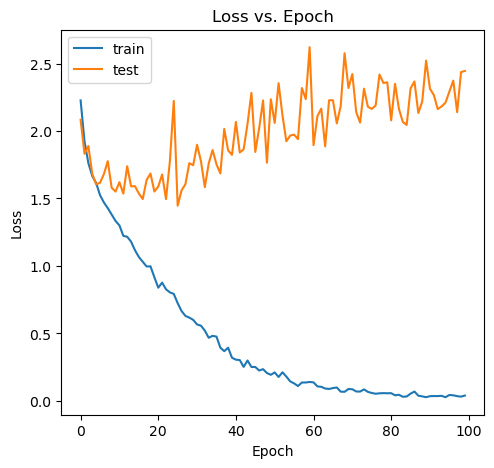

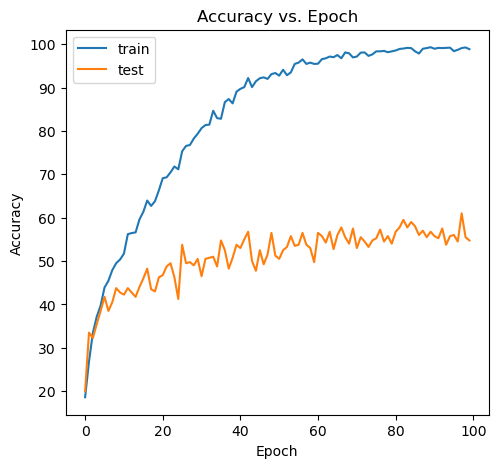

In [40]:
# 畫出 loss 和 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2(b)Remove the identity mapping

In [41]:
class ConvBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ConvBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )

    def forward(self, x):
        out = self.left(x)
        out = F.relu(out)
        return out

class Plain(nn.Module):
    def __init__(self, ConvlBlock, num_classes=10):
        super(Plain, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ConvlBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ConvlBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ConvlBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ConvlBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def CNN18():
    return Plain(ConvBlock)

In [42]:
# 模型定義-plain-18
net2 = CNN18().to(device)
# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #損失函數為交叉熵，多用於多分類問題
optimizer = optim.SGD(net2.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #優化方式為mini-batch momentum-SGD，並採用L2正則化（權重衰減）

In [43]:
if not os.path.exists('./model/plain18/'):
    os.makedirs('./model/plain18/')
    
# 初始化 best test accuracy
best_acc = 0
    
# 初始化 loss 和 accuracy 列表
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Start Training, plain-18!")

for epoch in range(EPOCH):
    net2.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    train_iter = tqdm(trainloader, total=len(trainloader))
    for i, data in enumerate(train_iter, 0):
        # 準備數據
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每訓練1個batch打印一次loss和準確率
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels.data).cpu().sum()
        train_iter.set_description('[epoch:%d/%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                % (epoch + 1, EPOCH, (i + 1 + epoch * length), train_loss / (i + 1), 100. * train_correct / train_total))

    # 計算訓練集 loss 和 accuracy
    train_loss /= len(trainloader)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #每訓練完一個epoch測試一下準確率
    # print("Waiting Test!")
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_iter = tqdm(testloader, total=len(testloader), desc='Testing')
        for data in test_iter:
            net2.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net2(images)
            # 取得分最高的那個類 (outputs.data的索引號)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum()
            test_loss += criterion(outputs, labels).item()
            test_iter.set_postfix({'epoch': f'{epoch+1}/{EPOCH}','loss': test_loss / (test_iter.n + 1), 'acc': '{:.4%}'.format(test_correct / test_total)})
        test_loss /= len(testloader)
        test_acc = 100. * test_correct.cpu() / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f"finish {epoch+1} epochs")
            
        # 保存模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(net2.state_dict(), '%s/net_best.pth' % ('./model/plain18/'))
            
print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training, plain-18!


[epoch:1/100, iter:40] Loss: 2.293 | Acc: 11.350% : 100%|██████████| 40/40 [00:07<00:00,  5.42it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, epoch=1/100, loss=2.64, acc=12.0000%]
[epoch:2/100, iter:80] Loss: 2.120 | Acc: 21.200% : 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, epoch=2/100, loss=2.36, acc=21.7500%]
[epoch:3/100, iter:120] Loss: 1.917 | Acc: 27.850% : 100%|██████████| 40/40 [00:06<00:00,  6.07it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.30it/s, epoch=3/100, loss=1.83, acc=32.7500%]
[epoch:4/100, iter:160] Loss: 1.811 | Acc: 31.600% : 100%|██████████| 40/40 [00:06<00:00,  5.92it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s, epoch=4/100, loss=2.86, acc=32.5000%]
[epoch:5/100, iter:200] Loss: 1.723 | Acc: 33.200% : 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  3.26it/s, epoch=5/100, loss=1.99, acc=35.2500%]
[epoch:6/100, iter:240] Loss: 1.

finish 10 epochs


[epoch:11/100, iter:440] Loss: 1.397 | Acc: 48.000% : 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s, epoch=11/100, loss=2.03, acc=45.5000%]
[epoch:12/100, iter:480] Loss: 1.359 | Acc: 49.600% : 100%|██████████| 40/40 [00:07<00:00,  5.27it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s, epoch=12/100, loss=1.8, acc=42.5000%] 
[epoch:13/100, iter:520] Loss: 1.322 | Acc: 51.050% : 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s, epoch=13/100, loss=1.73, acc=40.2500%]
[epoch:14/100, iter:560] Loss: 1.279 | Acc: 53.700% : 100%|██████████| 40/40 [00:07<00:00,  5.13it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, epoch=14/100, loss=1.98, acc=42.0000%]
[epoch:15/100, iter:600] Loss: 1.246 | Acc: 54.200% : 100%|██████████| 40/40 [00:07<00:00,  5.43it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s, epoch=15/100, loss=1.89, acc=42.2500%]
[epoch:16/100, iter:

finish 20 epochs


[epoch:21/100, iter:840] Loss: 1.006 | Acc: 64.550% : 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, epoch=21/100, loss=1.97, acc=42.5000%]
[epoch:22/100, iter:880] Loss: 0.973 | Acc: 65.600% : 100%|██████████| 40/40 [00:07<00:00,  5.55it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, epoch=22/100, loss=1.7, acc=46.5000%] 
[epoch:23/100, iter:920] Loss: 0.941 | Acc: 66.150% : 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.67it/s, epoch=23/100, loss=1.48, acc=49.2500%]
[epoch:24/100, iter:960] Loss: 0.904 | Acc: 68.550% : 100%|██████████| 40/40 [00:07<00:00,  5.50it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s, epoch=24/100, loss=2.52, acc=39.0000%]
[epoch:25/100, iter:1000] Loss: 0.841 | Acc: 70.300% : 100%|██████████| 40/40 [00:07<00:00,  5.17it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s, epoch=25/100, loss=1.49, acc=48.0000%]
[epoch:26/100, iter

finish 30 epochs


[epoch:31/100, iter:1240] Loss: 0.678 | Acc: 76.450% : 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, epoch=31/100, loss=1.86, acc=42.2500%]
[epoch:32/100, iter:1280] Loss: 0.577 | Acc: 80.450% : 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, epoch=32/100, loss=2.01, acc=49.5000%]
[epoch:33/100, iter:1320] Loss: 0.542 | Acc: 82.200% : 100%|██████████| 40/40 [00:07<00:00,  5.27it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s, epoch=33/100, loss=1.95, acc=51.5000%]
[epoch:34/100, iter:1360] Loss: 0.529 | Acc: 80.850% : 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, epoch=34/100, loss=2.04, acc=49.0000%]
[epoch:35/100, iter:1400] Loss: 0.540 | Acc: 80.300% : 100%|██████████| 40/40 [00:07<00:00,  5.35it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s, epoch=35/100, loss=2.04, acc=50.0000%]
[epoch:36/100, 

finish 40 epochs


[epoch:41/100, iter:1640] Loss: 0.418 | Acc: 85.600% : 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, epoch=41/100, loss=2.02, acc=48.2500%]
[epoch:42/100, iter:1680] Loss: 0.432 | Acc: 84.600% : 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, epoch=42/100, loss=2.23, acc=45.2500%]
[epoch:43/100, iter:1720] Loss: 0.348 | Acc: 88.250% : 100%|██████████| 40/40 [00:07<00:00,  5.49it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, epoch=43/100, loss=2.21, acc=50.2500%]
[epoch:44/100, iter:1760] Loss: 0.304 | Acc: 89.850% : 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s, epoch=44/100, loss=1.86, acc=50.0000%]
[epoch:45/100, iter:1800] Loss: 0.319 | Acc: 88.900% : 100%|██████████| 40/40 [00:07<00:00,  5.51it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, epoch=45/100, loss=2.6, acc=45.2500%] 
[epoch:46/100, 

finish 50 epochs


[epoch:51/100, iter:2040] Loss: 0.204 | Acc: 93.100% : 100%|██████████| 40/40 [00:07<00:00,  5.47it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, epoch=51/100, loss=2.29, acc=51.0000%]
[epoch:52/100, iter:2080] Loss: 0.216 | Acc: 92.950% : 100%|██████████| 40/40 [00:07<00:00,  5.58it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, epoch=52/100, loss=2.48, acc=51.0000%]
[epoch:53/100, iter:2120] Loss: 0.236 | Acc: 92.350% : 100%|██████████| 40/40 [00:07<00:00,  5.54it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s, epoch=53/100, loss=2.43, acc=48.7500%]
[epoch:54/100, iter:2160] Loss: 0.233 | Acc: 92.400% : 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s, epoch=54/100, loss=2.44, acc=48.2500%]
[epoch:55/100, iter:2200] Loss: 0.176 | Acc: 94.650% : 100%|██████████| 40/40 [00:07<00:00,  5.32it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s, epoch=55/100, loss=1.86, acc=54.5000%]
[epoch:56/100, 

finish 60 epochs


[epoch:61/100, iter:2440] Loss: 0.155 | Acc: 95.150% : 100%|██████████| 40/40 [00:07<00:00,  5.47it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s, epoch=61/100, loss=3.65, acc=47.0000%]
[epoch:62/100, iter:2480] Loss: 0.151 | Acc: 95.250% : 100%|██████████| 40/40 [00:07<00:00,  5.51it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, epoch=62/100, loss=2.06, acc=49.0000%]
[epoch:63/100, iter:2520] Loss: 0.146 | Acc: 95.350% : 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s, epoch=63/100, loss=2.32, acc=50.7500%]
[epoch:64/100, iter:2560] Loss: 0.151 | Acc: 94.850% : 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, epoch=64/100, loss=3.8, acc=51.2500%] 
[epoch:65/100, iter:2600] Loss: 0.129 | Acc: 95.700% : 100%|██████████| 40/40 [00:07<00:00,  5.54it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, epoch=65/100, loss=2.32, acc=53.7500%]
[epoch:66/100, 

finish 70 epochs


[epoch:71/100, iter:2840] Loss: 0.086 | Acc: 97.550% : 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s, epoch=71/100, loss=2.34, acc=54.0000%]
[epoch:72/100, iter:2880] Loss: 0.088 | Acc: 97.450% : 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, epoch=72/100, loss=2.11, acc=56.0000%]
[epoch:73/100, iter:2920] Loss: 0.083 | Acc: 97.700% : 100%|██████████| 40/40 [00:07<00:00,  5.32it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, epoch=73/100, loss=1.96, acc=55.2500%]
[epoch:74/100, iter:2960] Loss: 0.085 | Acc: 97.550% : 100%|██████████| 40/40 [00:07<00:00,  5.47it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.48it/s, epoch=74/100, loss=2.56, acc=57.2500%]
[epoch:75/100, iter:3000] Loss: 0.085 | Acc: 97.400% : 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s, epoch=75/100, loss=2.57, acc=51.7500%]
[epoch:76/100, 

finish 80 epochs


[epoch:81/100, iter:3240] Loss: 0.069 | Acc: 97.650% : 100%|██████████| 40/40 [00:07<00:00,  5.15it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s, epoch=81/100, loss=2.07, acc=54.7500%]
[epoch:82/100, iter:3280] Loss: 0.046 | Acc: 98.650% : 100%|██████████| 40/40 [00:07<00:00,  5.17it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, epoch=82/100, loss=2.04, acc=53.0000%]
[epoch:83/100, iter:3320] Loss: 0.070 | Acc: 98.100% : 100%|██████████| 40/40 [00:07<00:00,  5.41it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, epoch=83/100, loss=3.16, acc=55.5000%]
[epoch:84/100, iter:3360] Loss: 0.058 | Acc: 98.500% : 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s, epoch=84/100, loss=2.89, acc=52.2500%]
[epoch:85/100, iter:3400] Loss: 0.084 | Acc: 97.300% : 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, epoch=85/100, loss=2.47, acc=51.7500%]
[epoch:86/100, 

finish 90 epochs


[epoch:91/100, iter:3640] Loss: 0.082 | Acc: 97.550% : 100%|██████████| 40/40 [00:07<00:00,  5.10it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s, epoch=91/100, loss=2.67, acc=50.0000%]
[epoch:92/100, iter:3680] Loss: 0.064 | Acc: 98.250% : 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]
Testing: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s, epoch=92/100, loss=2.34, acc=55.7500%]
[epoch:93/100, iter:3720] Loss: 0.060 | Acc: 98.050% : 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, epoch=93/100, loss=2.38, acc=54.5000%]
[epoch:94/100, iter:3760] Loss: 0.048 | Acc: 98.700% : 100%|██████████| 40/40 [00:07<00:00,  5.46it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, epoch=94/100, loss=2.44, acc=57.0000%]
[epoch:95/100, iter:3800] Loss: 0.049 | Acc: 98.650% : 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]
Testing: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, epoch=95/100, loss=4.01, acc=56.0000%]
[epoch:96/100, 

finish 100 epochs
Training Finished, TotalEPOCH=100


### Plain18 Result

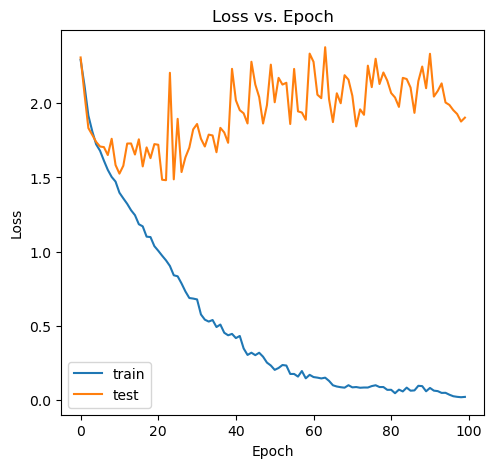

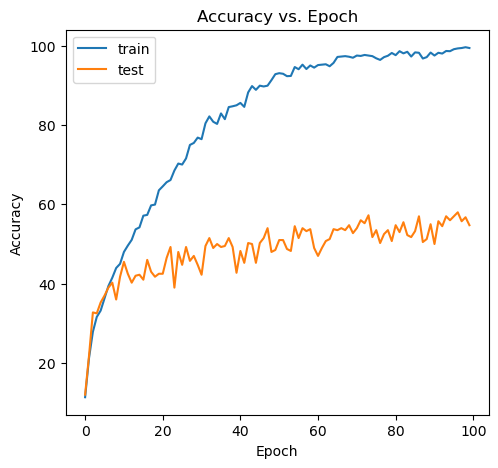

In [44]:
# 畫出 loss 和 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製 accuracy 曲線圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

討論:ResNet中的identity mapping是指將前一層的輸入直接添加到後一層的輸出中，以保持信息的傳遞。如果刪除identity mapping，對於深層網路可能會導致信息流失，從而影響模型的性能。但在2(a)及2(b)的結果中，並沒有看出明顯的差異，與論文結果相符(ResNet18與plain18性能差異不大)，兩個網路訓練集和測時集的結果差異非常大，也顯示出網路overfitting的問題，可能原因為資料不足、模型過深...等。